# Semester Project Notebook - EPFL HP

In [2]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# 01 - Fluid selection

### Legislation: banned fluids (Montreal Protocol, OFEV)
Fluid with ozone depletion potention, global warming potential and stable in the atmosphere.
- HCFC
- HCFO
- CFC
- HFC

### Environmental Criteria
- GWPmax = 400 
- ODPmax = 0

### Operating Criteria
- Tcrit,min  = 90°C (to avoid entering the supercritical domain)
- Teb,max = 10°C (if Teb too high, very low pressure required for evaporation)
    
### Fluid screening
Selected for the study: Fluids figuring in the (non-exhaustive) OFEV's list of autorized fluids:
- R-290 (propane, HC)
- R-600 (butane, HC)
- R-600a (isobutane, HC)
- R-1270 (propylène, HO)
- R-1234yf (HFO)
- R-1234ze (HFO)
- R-717 (ammonia, N)

Not selected for the study: Fluids not in the list:
- R-630 (methylamine, HC)
- R-40 (HCC)
- R-1140 (HCO)
- R-764 (sulfure dioxide, N)
    
### Physical properties for unknown fluids in Belsim VALI (R-1234yf, R-1234ze)
- Thermodynamic models: VIDEAL/LIDEAL or Soave/Peng-Robinson
- Physical properties required: critical temperature, critical pressure, boiling curve coefficients, ascentric factor

In [16]:
properties = {'ASHRAE': ['R-1234yf','R-1234ze'], 'Formula':['C3F4H2','C3F4H2'], 'Tcrit [K]':[367.85,423.27], 'Pcrit [bar]':[33.822, 35.349], 'PVAP':['?','?'], 'omega':[0.276,0.326]}
properties = pd.DataFrame(properties)
properties = properties.set_index('ASHRAE')
properties

,Formula,Tcrit [K],Pcrit [bar],PVAP,omega
ASHRAE,,,,,
R-1234yf,C3F4H2,367.85,33.822,?,0.276
R-1234ze,C3F4H2,423.27,35.349,?,0.326


# 02 - Heating demand

Monthly mean heating demand during operating hours for the two heating loops (lowT (50°C) and mediumT (65°C)) of EPFL's heating system. 

In [2]:
heating_demand = pd.read_csv('Data/heating_monthly.csv', sep=';')
heating_demand = heating_demand.set_index('Month')
heating_demand['MT'] = heating_demand['MT'].apply(lambda x: x/1000 if x > 0 else 0)
heating_demand['LT'] = heating_demand['LT'].apply(lambda x: x/1000 if x > 0 else 0)
heating_demand.rename(columns={'MT':'MT [kW]', 'LT':'LT [kW]'})

,MT [kW],LT [kW]
Month,,
1,7395.670705,4318.682087
2,5534.986003,3283.383266
3,2904.392606,1811.057933
4,43.868802,192.982501
5,0.000000,0.000000
6,0.000000,0.000000
7,0.000000,0.000000
8,0.000000,0.000000
9,0.000000,36.520003


# 02bis - New heating demand

In [9]:
heating_demand = pd.read_csv('Data/Q_demand_building.csv', sep=',',header=None)
heating_demand.head()

,0,1,2,3,4,5,6,7,8,9,...,8751,8752,8753,8754,8755,8756,8757,8758,8759,8760
0,2,0,0,0,0,0,0,0,226430.0,210880.0,...,275270.0,303100.0,332460.0,349760.0,377250.0,382990.0,394460.0,0,0,0
1,2,0,0,0,0,0,0,0,383690.0,351220.0,...,429130.0,478850.0,524220.0,562730.0,615950.0,624280.0,640940.0,0,0,0
2,2,0,0,0,0,0,0,0,693060.0,638070.0,...,826050.0,915530.0,1004900.0,1067900.0,1162100.0,1179500.0,1214400.0,0,0,0
3,1,0,0,0,0,0,0,0,1931800.0,1820800.0,...,2476700.0,2704800.0,2970100.0,3085200.0,3295800.0,3349400.0,3456700.0,0,0,0
4,2,0,0,0,0,0,0,0,851280.0,788660.0,...,1012600.0,1119000.0,1226900.0,1298100.0,1406100.0,1426900.0,1468500.0,0,0,0


In [108]:
monthly_Q = {'Month': np.arange(1,13), 'Heat load LT': np.zeros(12), 'Heat load MT': np.zeros(12), 'Operating hours LT': np.zeros(12), 'Operating hours MT': np.zeros(12)}
monthly_Q = pd.DataFrame(monthly_Q)
monthly_Q = monthly_Q.set_index('Month')

month_day = np.array([31,28,31,30,31,30,31,31,30,31,30,31])
month_end = month_day.cumsum()*24


for building in np.arange(0,24):
    month = 1
    working_hours_MT_building = np.zeros(12)
    working_hours_LT_building = np.zeros(12)
    Q_building_MT = np.zeros(12)
    Q_building_LT = np.zeros(12)
    
    for hour in np.arange(1,8761):
        if (hour <= month_end[month-1]):
            if (heating_demand.loc[building,hour] > 0):
                if (heating_demand.loc[building,0] == 1):
                    Q_building_MT[month-1] = Q_building_MT[month-1] + heating_demand.loc[building,hour]
                    working_hours_MT_building[month-1] = working_hours_MT_building[month-1] + 1
                else: 
                    Q_building_LT[month-1] = Q_building_LT[month-1] + heating_demand.loc[building,hour]
                    working_hours_LT_building[month-1] = working_hours_LT_building[month-1] + 1
        else: 
            month = month + 1
    for i in np.arange(1,13):
        if (heating_demand.loc[building,0] == 1):
            if (working_hours_MT_building[i-1] > 0):
                monthly_Q.loc[i,'Heat load MT'] = monthly_Q.loc[i,'Heat load MT'] + Q_building_MT[i-1]/working_hours_MT_building[i-1]
                monthly_Q.loc[i,'Operating hours MT'] = (monthly_Q.loc[i,'Operating hours MT'] + working_hours_MT_building[i-1])/2
        else:
            if (working_hours_LT_building[i-1] > 0):
                monthly_Q.loc[i,'Heat load LT'] = monthly_Q.loc[i,'Heat load LT'] + Q_building_LT[i-1]/working_hours_LT_building[i-1]
                monthly_Q.loc[i,'Operating hours LT'] = (monthly_Q.loc[i,'Operating hours LT'] + working_hours_LT_building[i-1])/2

monthly_Q



,Heat load LT,Heat load MT,Operating hours LT,Operating hours MT
Month,,,,
1,1.035883e+07,1.720648e+07,320.564331,320.696289
2,8.576340e+06,1.425147e+07,269.229614,265.329102
3,6.183220e+06,1.019181e+07,248.865479,239.658203
4,4.102471e+06,6.501681e+06,131.753662,123.336914
5,2.414567e+06,3.711414e+06,52.919006,43.373047
6,1.713424e+06,2.404177e+06,8.312378,5.216797
7,0.000000e+00,0.000000e+00,0.000000,0.000000
8,6.660741e+05,4.636565e+05,4.251221,1.179688
9,2.829082e+06,4.379031e+06,73.529297,66.415039


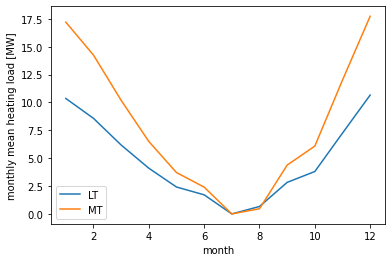

In [110]:
plt.plot(np.arange(1,13), monthly_Q['Heat load LT']/1000000, label = 'LT')
plt.plot(np.arange(1,13), monthly_Q['Heat load MT']/1000000, label = 'MT')
plt.legend()
plt.xlabel('month')
plt.ylabel('monthly mean heating load [MW]')
plt.show()

In [62]:
monthly_Q['LT'] = monthly_Q['LT']/working_hours_LT
monthly_Q
working_hours_LT

array([4480., 3754., 3436., 1774.,  671.,   89.,    0.,   27.,  948.,
       2261., 3875., 4052.])

In [74]:
test = np.ones(5)
test2 = np.ones(5)*2
test/test2

array([0.5, 0.5, 0.5, 0.5, 0.5])

# 03 - Compressor isentropic efficiency under partial load conditions

### Assumptions
- head is constant
- nominal conditions for typical period with higher massflow rate
- linear relationship between the massflow rate and the isentropic efficiency
https://docs.lib.purdue.edu/cgi/viewcontent.cgi?article=2826&context=icec
- 100% massflow rate: 100% of nominal efficiency -> $\eta_{is}$ = 0.85
- 40% massflow rate: 60% of nominal efficiency -> $\eta_{is}$ = 0.51

### Linear regression

$\eta_{is} = 0.5667 \cdot \frac{\dot{m}}{\dot{m}_{max}} + 0.2833$

                            OLS Regression Results                            
Dep. Variable:                 is_eff   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 03 Nov 2020   Prob (F-statistic):                nan
Time:                        07:53:00   Log-Likelihood:                 71.329
No. Observations:                   2   AIC:                            -138.7
Df Residuals:                       0   BIC:                            -141.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2833        inf          0        n

/Users/sylvainclement/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/stattools.py:70: ValueWarning: omni_normtest is not valid with less than 8 observations; 2 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/sylvainclement/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1698: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/sylvainclement/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1698: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/sylvainclement/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1620: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


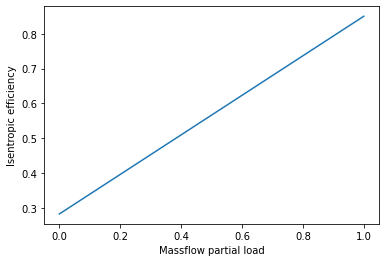

In [170]:
data = {'is_eff': [0.51,0.85], 'perc_flow':[0.4,1]}
data = pd.DataFrame(data)

results = smf.ols('is_eff ~ perc_flow', data=data).fit()

print(results.summary())

a = results.params.values[1]
b = results.params.values[0]

ax = plt.figure()
plt.plot((0,1),a*np.array([0,1]) + b)
plt.xlabel('Massflow partial load')
plt.ylabel('Isentropic efficiency')
plt.show()

# 04 - Optimal condensation temperature (HP_T_6)

### Working assumptions
- HP design optimized for colder working conditions (Q_ cond = 6 MW)
- isentropic compressor efficiency: 0.85
- same pressure ratio for the 2 compressors
- boiling temperature at the evaporator is constant (6°C)
- water enters in EPFL with T_EPFL_in = 65/50 °C and leaves EPFL with T_EPFL_out = 30°C
- CO2 emissions from gird electricity: 0.206 kgCO2eq/kWh
- swiss CO2 tax: 100 CHF/t CO2
- electricity price: 0.0916 CHF/kWh
- lifetime = 20 years
- global heat transfer coefficient water to refrigerant (evaporator): Uevap = 0.8 kW/m2/K https://www.engineersedge.com/thermodynamics/overall_heat_transfer-table.htm
- global heat transfer coefficient refrigerant to water (condensor): Ucond = 0.8 kW/m2/k
https://www.engineersedge.com/thermodynamics/overall_heat_transfer-table.htm

### Flowchart of the Belsim VALI Model
Imposed conditions (CST) are marked in yellow

<img src=flowchart_optimal_t_hp_6.png>

### Compressor and heat exchanger cost calculation (CAPEX)

$A_{HEX} = \frac{Q_{cond}}{U \cdot LMDT} $

$C_p = 10^{K_1 + K_2\cdot \log(A) + K_3 \cdot \log(A)^2} \cdot \frac{I_t}{I_{t,ref}}$
where $A$ is the HEX area in [m2] or the compressor power in [kW].

$C = F_{BM} \cdot C_p$

$CAPEX = C \cdot \frac{i(i+1)^n}{(i+1)^n-1}$ [CHF/year]

In [2]:
cost_parameters = {'Equipment': ['Compressor','Condensor','Evaporator'], 'Fbm':[2.45,4.74,4.74], 'K1':[2.2897,3.2138,3.5638], 'K2':[1.3604,0.2688,0.1906], 'K3':[-0.1027,0.07961,0.1107], 'Iref':[394.3,394.3,394.3], 'It':[584.6, 584.6,584.6]}
cost_parameters = pd.DataFrame(cost_parameters)
cost_parameters = cost_parameters.set_index('Equipment')
cost_parameters

,Fbm,K1,K2,K3,Iref,It
Equipment,,,,,,
Compressor,2.45,2.2897,1.3604,-0.10270,394.3,584.6
Condensor,4.74,3.2138,0.2688,0.07961,394.3,584.6
Evaporator,4.74,3.5638,0.1906,0.11070,394.3,584.6


### Operation costs (OPEX)

$OPEX = \sum_i^{period} E_i (c_{el} + grid_{CO_2} \cdot tax_{CO2})$

### Results from VALI
Iteration of the model over T_HP_6 for each typical period

In [3]:
result_VALI = pd.read_csv('Data/R-717_all_Results.csv', sep=',')
result_VALI

,month,W_COMP_1,W_COMP_2,Q_COND_LOAD,Q_EVAP_LOAD,T_HP_1,T_HP_5,T_HP_6
0,1,289.092,326.610,6000.0,5384.30,6,49.7586,30
1,1,299.751,340.400,6000.0,5359.85,6,51.5175,31
2,1,310.304,354.207,6000.0,5335.49,6,53.2714,32
3,1,320.753,368.031,6000.0,5311.22,6,55.0201,33
4,1,331.098,381.872,6000.0,5287.03,6,56.7639,34
...,...,...,...,...,...,...,...,...
107,12,400.651,479.268,6000.0,5120.08,6,68.8302,41
108,12,410.185,493.260,6000.0,5096.56,6,70.5342,42
109,12,419.620,507.273,6000.0,5073.11,6,72.2333,43
110,12,428.957,521.307,6000.0,5049.74,6,73.9276,44


### Computations and plot for optimization

In [97]:
# Condenser design for maximal load
T_EPFL_MT_in = 65
T_EPFL_LT_in = 50
T_EPFL_out = 30
U = 0.8
i = 0.08
n =20

data_max_load = result_VALI[result_VALI['month']==1]
data_max_load['LMTD'] = data_max_load.apply(lambda x: ((x.T_HP_5-T_EPFL_MT_in)-(x.T_HP_6-T_EPFL_out))/(np.log(x.T_HP_5-T_EPFL_MT_in)-np.log(x.T_HP_6-T_EPFL_out)),axis=1)
# Filtering out not possible T conditions
data_max_load = data_max_load.dropna()
data_max_load['A_condensor'] = data_max_load.apply(lambda x: x.Q_COND_LOAD/U/x.LMTD, axis=1)

# Evaporator design
LMTD_evap = ((7-2)-(3-2))/(np.log(7-2)-np.log(3-2))
data_max_load['A_evaporator'] = data_max_load.apply(lambda x: x.Q_EVAP_LOAD/U/x.LMTD, axis=1)

# Cost condensor
data_max_load['c_HEX_cond'] = data_max_load.apply(lambda x: cost_parameters.loc['Condensor','It']/cost_parameters.loc['Condensor','Iref']*cost_parameters.loc['Condensor','Fbm']*(10**(cost_parameters.loc['Condensor','K1']+cost_parameters.loc['Condensor','K2']*np.log10(x.A_condensor)+cost_parameters.loc['Condensor','K3']*(np.log10(x.A_condensor)**2))),axis=1)

# Cost evaporator
data_max_load['c_HEX_evap'] = data_max_load.apply(lambda x: cost_parameters.loc['Evaporator','It']/cost_parameters.loc['Evaporator','Iref']*cost_parameters.loc['Evaporator','Fbm']*(10**(cost_parameters.loc['Evaporator','K1']+cost_parameters.loc['Evaporator','K2']*np.log10(x.A_evaporator)+cost_parameters.loc['Evaporator','K3']*(np.log10(x.A_evaporator)**2))),axis=1)

# Cost compressor
data_max_load['c_compressor'] = data_max_load.apply(lambda x: cost_parameters.loc['Compressor','It']/cost_parameters.loc['Compressor','Iref']*cost_parameters.loc['Compressor','Fbm']*(10**(cost_parameters.loc['Compressor','K1']+cost_parameters.loc['Compressor','K2']*np.log10(x.W_COMP_1)+cost_parameters.loc['Compressor','K3']*(np.log10(x.W_COMP_1)**2)))++ cost_parameters.loc['Compressor','It']/cost_parameters.loc['Compressor','Iref']*cost_parameters.loc['Compressor','Fbm']*(10**(cost_parameters.loc['Compressor','K1']+cost_parameters.loc['Compressor','K2']*np.log10(x.W_COMP_2)+cost_parameters.loc['Compressor','K3']*(np.log10(x.W_COMP_2)**2))),axis=1)

# CAPEX
data_max_load['CAPEX'] = data_max_load.apply(lambda x: (x.c_HEX_cond + x.c_HEX_evap + x.c_compressor)*i*((i+1)**n)/(((i+1)**n)-1),axis=1)

data_max_load = data_max_load.set_index('T_HP_6')

data_max_load



<ipython-input-97-c103acf1ef5b>:10: RuntimeWarning: invalid value encountered in log
  data_max_load['LMTD'] = data_max_load.apply(lambda x: ((x.T_HP_5-T_EPFL_MT_in)-(x.T_HP_6-T_EPFL_out))/(np.log(x.T_HP_5-T_EPFL_MT_in)-np.log(x.T_HP_6-T_EPFL_out)),axis=1)
<ipython-input-97-c103acf1ef5b>:10: RuntimeWarning: divide by zero encountered in log
  data_max_load['LMTD'] = data_max_load.apply(lambda x: ((x.T_HP_5-T_EPFL_MT_in)-(x.T_HP_6-T_EPFL_out))/(np.log(x.T_HP_5-T_EPFL_MT_in)-np.log(x.T_HP_6-T_EPFL_out)),axis=1)
<ipython-input-97-c103acf1ef5b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_max_load['LMTD'] = data_max_load.apply(lambda x: ((x.T_HP_5-T_EPFL_MT_in)-(x.T_HP_6-T_EPFL_out))/(np.log(x.T_HP_5-T_EPFL_MT_in)-np.log(x.T_HP_6-T_EPFL_out

,month,W_COMP_1,W_COMP_2,Q_COND_LOAD,Q_EVAP_LOAD,T_HP_1,T_HP_5,LMTD,A_condensor,A_evaporator,c_HEX_cond,c_HEX_evap,c_compressor,CAPEX
T_HP_6,,,,,,,,,,,,,,
39,1,381.284,451.345,6000.0,5167.37,6,65.4074,2.776119,2701.613324,2326.705940,832762.291159,2.028103e+06,1.021796e+06,395457.697035
40,1,391.017,465.296,6000.0,5143.69,6,67.1213,5.081210,1476.026487,1265.370447,515227.067793,1.167462e+06,1.045541e+06,277876.229423
41,1,400.651,479.268,6000.0,5120.08,6,68.8302,6.796159,1103.564519,941.723104,412660.581296,9.046805e+05,1.069013e+06,243055.468635
42,1,410.185,493.260,6000.0,5096.56,6,70.5342,8.354183,897.753908,762.576109,353760.109936,7.579142e+05,1.092218e+06,224471.328287
43,1,419.620,507.273,6000.0,5073.11,6,72.2333,9.836521,762.464660,644.677848,313824.230413,6.603292e+05,1.115164e+06,212801.577818
44,1,428.957,521.307,6000.0,5049.74,6,73.9276,11.274262,665.232032,559.874800,284349.044847,5.893907e+05,1.137857e+06,204885.556001
45,1,438.197,535.364,6000.0,5026.44,6,75.6170,12.682522,591.365009,495.410122,261422.770837,5.348926e+05,1.160306e+06,199286.179206


In [101]:
# OPEX
grid_CO2 = 0.206/1000 #tCO2/kWh
c_el = 0.0916 #CHF/kWh
tax_CO2 = 100 #CHF/tCO2
operating_hours = 458 #h

scenarios = {'T_HP_6': np.arange(39,46), 'W':np.zeros(7), 'OPEX':np.zeros(7), 'CAPEX':np.zeros(7), 'TOTEX':np.zeros(7)}
scenarios = pd.DataFrame(scenarios)
scenarios = scenarios.set_index('T_HP_6')

scenarios['CAPEX'] = data_max_load['CAPEX'].copy()

for T_HP_6 in np.arange(39,46):
    scenarios.loc[T_HP_6,'W'] = result_VALI[result_VALI['T_HP_6']==T_HP_6].W_COMP_1.sum() + result_VALI[result_VALI['T_HP_6']==T_HP_6].W_COMP_2.sum()
    scenarios.loc[T_HP_6,'OPEX'] = scenarios.loc[T_HP_6,'W']*operating_hours*(c_el + tax_CO2*grid_CO2)
    scenarios.loc[T_HP_6,'TOTEX'] = scenarios.loc[T_HP_6,'OPEX'] + scenarios.loc[T_HP_6,'CAPEX']

scenarios


,W,OPEX,CAPEX,TOTEX
T_HP_6,,,,
39,3557.29178,182800.687074,395457.697035,578258.384109
40,3658.47973,188000.492973,277876.229423,465876.722396
41,3759.33330,193183.115887,243055.468635,436238.584522
42,3859.84360,198348.098979,224471.328287,422819.427266
43,3960.02162,203496.007000,212801.577818,416297.584818
44,4059.87268,208627.113331,204885.556001,413512.669332
45,4159.40279,213741.726811,199286.179206,413027.906017


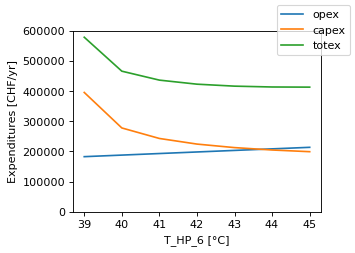

In [130]:
#Plot
ax = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
plt.ylim((0,600000))
plt.plot(scenarios.index.values,scenarios['OPEX'],label='opex')
plt.plot(scenarios.index.values,scenarios['CAPEX'],label='capex')
plt.plot(scenarios.index.values,scenarios['TOTEX'],label='totex')
ax.legend()
plt.xlabel('T_HP_6 [°C]')
plt.ylabel('Expenditures [CHF/yr]')
plt.show()

# TO DO
- vérifier demande
- corriger demande dans tags
- vérifier évaporateur
- corriger models
- résoudre T_HP_6 optimal
- résoudre pour tous les fluids
- pour chaque fluid: TOTEX + COP(Text)
- 2ème configuration

